# Description

The idea of this notebook is to explore the results of a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene pvalues).
Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors in some LVs.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "covars"
    / "_corrs_all"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Load MultiXcan genes present in results

In [5]:
_tmp = pd.read_csv(
    conf.RESULTS["GLS_NULL_SIMS"]
    / "twas"
    / "smultixcan"
    / "random.pheno0-gtex_v8-mashr-smultixcan.txt",
    sep="\t",
)

In [6]:
_tmp.shape

(22317, 18)

In [7]:
_tmp.head()

,gene,gene_name,pvalue,n,n_indep,p_i_best,t_i_best,p_i_worst,t_i_worst,eigen_max,eigen_min,eigen_min_kept,z_min,z_max,z_mean,z_sd,tmi,status
0,ENSG00000131941.7,RHPN2,0.000040,48.0,3.0,2.139470e-04,Artery_Tibial,0.990132,Brain_Nucleus_accumbens_basal_ganglia,36.556432,7.692089e-16,2.519701,-2.721185,3.701952,1.283152,1.825567,3.0,0
1,ENSG00000076650.6,GPATCH1,0.000078,40.0,3.0,4.534390e-04,Brain_Cerebellum,0.817384,Brain_Frontal_Cortex_BA9,29.990208,2.086487e-15,1.815203,-3.506853,2.383485,-2.016745,1.715495,3.0,0
2,ENSG00000100906.10,NFKBIA,0.000096,1.0,1.0,9.591208e-05,Brain_Frontal_Cortex_BA9,0.000096,Brain_Frontal_Cortex_BA9,1.000000,1.000000e+00,1.000000,-3.900707,-3.900707,-3.900707,NaN,1.0,0
3,ENSG00000136319.11,TTC5,0.000109,47.0,5.0,1.402826e-03,Brain_Hippocampus,0.961887,Colon_Sigmoid,21.272442,8.142339e-16,0.732606,-3.194069,1.397514,-0.916662,1.068989,5.0,0
4,ENSG00000152990.13,ADGRA3,0.000135,41.0,12.0,3.211289e-07,Heart_Atrial_Appendage,0.653657,Whole_Blood,12.988248,3.499412e-16,0.444682,-5.110605,3.599410,-0.464735,2.316607,12.0,0


In [8]:
multixcan_genes = set(_tmp["gene_name"])
display(len(multixcan_genes))
display(list(multixcan_genes)[:10])

22311

['CLEC3A',
 'LINC01566',
 'TRAPPC6B',
 'ST3GAL1',
 'RFTN1',
 'SMKR1',
 'RP11-521D12.2',
 'KCNK5',
 'WLS',
 'SQLE']

# Load MultiPLIER Z matrix

In [9]:
multiplier_z = pd.read_pickle(conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"])

In [10]:
multiplier_z.shape

(6750, 987)

In [11]:
# keep genes only present in MultiXcan
multiplier_z = multiplier_z.loc[
    sorted(multixcan_genes.intersection(multiplier_z.index))
]

In [12]:
multiplier_z.shape

(6446, 987)

In [13]:
multiplier_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
A2M,0.000000,0.000000,0.000000,0.078428,0.0,0.00000,0.000000,0.046772,0.000000,0.011033,...,0.010910,0.000000,0.052869,0.012749,0.0,0.013982,0.152241,0.000000,0.000000,0.108884
AAAS,0.271162,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,1.513337,0.000000,...,0.000000,0.000000,0.000000,0.001385,0.0,0.000000,0.711896,0.030534,0.447105,0.424685
AANAT,0.005099,0.308497,0.028815,0.000000,0.0,0.00000,0.371725,0.000000,0.135238,0.000000,...,0.117163,0.018815,0.000000,0.193142,0.0,0.040401,0.180436,0.000000,0.000000,0.042064
AARS,0.512978,0.000000,0.451285,0.319568,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006208,0.021274,0.0,0.000000,0.062143,0.000000,0.000000,0.364892
AARS2,1.008157,0.000000,0.197424,0.024832,0.0,0.57081,0.000000,0.228675,0.000000,0.116243,...,0.000000,0.000000,0.153345,0.000000,0.0,0.000000,1.004578,0.014470,0.000000,0.000000


# Functions

In [14]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [15]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [16]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [17]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [18]:
def get_lv_genes(lv_code):
    lv_genes = multiplier_z[lv_code].sort_values(ascending=False)
    lv_obj = LVAnalysis(lv_code)
    return lv_obj.lv_genes.set_index("gene_name").loc[lv_genes.index]

# Get files list

In [19]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [20]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [21]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [22]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [23]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [24]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV136,0.392807,0.124928,3.144278,0.001673,0.000836,random.pheno988
1,LV175,0.331246,0.124558,2.659377,0.007848,0.003924,random.pheno988
2,LV825,0.327867,0.124531,2.632814,0.008488,0.004244,random.pheno988
3,LV585,0.324938,0.124498,2.609978,0.009076,0.004538,random.pheno988
4,LV816,0.322478,0.124649,2.587083,0.009701,0.004850,random.pheno988


In [25]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [26]:
_mt1e = show_prop(dfs)
display(_mt1e)

0.058432624113475176

# QQ-plot

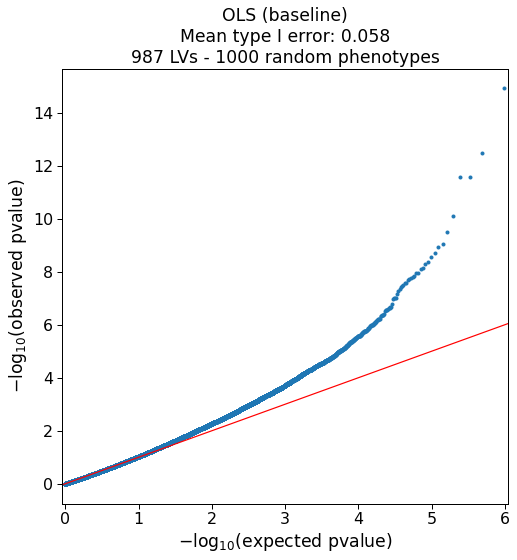

In [27]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(dfs[PVALUE_COLUMN])
    ax.set_title(
        f"OLS (baseline)\nMean type I error: {_mt1e:.3f}\n{N_LVS} LVs - {N_PHENOTYPES} random phenotypes"
    )

# Summary of mean type I error per LV

In [28]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [29]:
summary_df.shape

(987, 4)

In [30]:
summary_df.head()

,lv,1,5,10
0,LV1,0.007,0.025,0.067
1,LV10,0.012,0.041,0.079
2,LV100,0.016,0.051,0.083
3,LV101,0.018,0.040,0.094
4,LV102,0.013,0.057,0.083


In [31]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016133,0.058433,0.105536
std,0.006577,0.014026,0.019694
min,0.001000,0.015000,0.053000
25%,0.012000,0.049000,0.092000
50%,0.016000,0.058000,0.104000
75%,0.019000,0.067000,0.118000
max,0.074000,0.131000,0.190000


## LVs with expected type I error

In [32]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(82, 4)

,lv,1,5,10
934,LV940,0.014,0.049,0.086
578,LV62,0.015,0.049,0.089
753,LV778,0.010,0.049,0.096
746,LV771,0.015,0.049,0.098
386,LV447,0.008,0.049,0.090
395,LV455,0.016,0.049,0.098
398,LV458,0.011,0.049,0.085
257,LV330,0.010,0.049,0.096
407,LV466,0.012,0.049,0.094
702,LV731,0.006,0.049,0.081


,lv,1,5,10
11,LV109,0.015,0.051,0.082
843,LV859,0.016,0.051,0.089
120,LV207,0.016,0.051,0.100
225,LV301,0.009,0.051,0.083
330,LV397,0.011,0.051,0.093
252,LV326,0.013,0.051,0.089
787,LV808,0.011,0.051,0.096
785,LV806,0.012,0.051,0.090
334,LV40,0.018,0.051,0.098
754,LV779,0.012,0.051,0.093


## LVs with high type I error

In [33]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(411, 4)

,lv,1,5,10
253,LV327,0.031,0.090,0.134
975,LV978,0.028,0.090,0.148
151,LV235,0.031,0.091,0.135
672,LV704,0.021,0.093,0.157
501,LV550,0.038,0.093,0.148
632,LV669,0.024,0.094,0.156
707,LV736,0.025,0.094,0.155
542,LV588,0.017,0.096,0.155
417,LV475,0.031,0.097,0.160
694,LV724,0.032,0.097,0.166


Many LVs have a mean type I error greater than expected.

LV234, LV847 and LV45 are among the ones with the largest mean type I error (up to 0.131).

Let's take a look at these.

# LVs with high mean type I error

## LV234

In [34]:
lv_code = "LV234"

In [35]:
results = dfs[dfs["lv"] == lv_code]

In [36]:
results.shape

(1000, 7)

In [37]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
633,LV234,-0.055072,0.124777,-0.441365,0.658964,0.670518,random.pheno988
1801,LV234,-0.126632,0.124994,-1.013101,0.311050,0.844475,random.pheno589
2779,LV234,-0.110583,0.124856,-0.885683,0.375822,0.812089,random.pheno385
3535,LV234,-0.028683,0.124868,-0.229707,0.818327,0.590837,random.pheno5
4221,LV234,0.070714,0.124988,0.565771,0.571570,0.285785,random.pheno74


### Mean type I errors at different thresholds

In [38]:
show_prop(results, 0.01)

0.074

In [39]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.131

In [40]:
show_prop(results, 0.10)

0.165

In [41]:
show_prop(results, 0.15)

0.201

In [42]:
show_prop(results, 0.20)

0.236

### QQplot

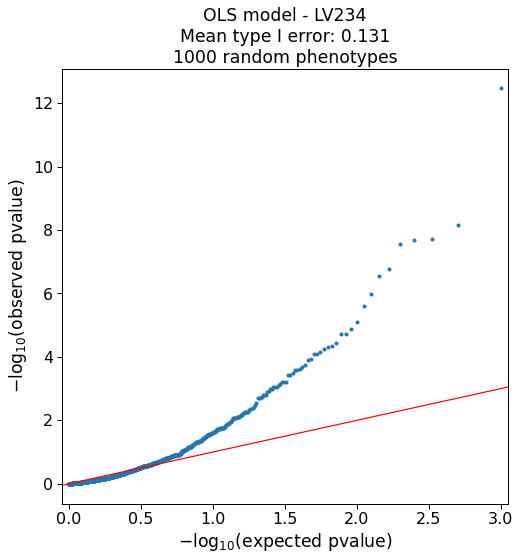

In [43]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [44]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV234,gene_band
HIST1H4E,7.379845,6p22.2
HIST1H3B,7.293635,6p22.2
HIST4H4,6.929394,12p12.3
HIST1H3H,6.863106,6p22.1
HIST1H3D,4.568047,6p22.2
HIST1H2BC,4.078396,6p22.2
HIST1H2AE,4.009782,6p22.2
HIST1H2BF,3.963254,6p22.2
HIST1H2BD,3.862981,6p22.2
HIST1H2BK,3.662444,6p22.1


In [45]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2      12
6p22.1       5
12p12.3      1
17q21.31     1
17q25.1      1
1q42.12      1
1q42.13      1
11q23.3      1
4q23         1
16p11.2      1
Name: gene_band, dtype: int64

**Note**: top genes from the same band.

In [46]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [47]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(1756, 2)

In [48]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19q13.2     22
16p13.3     21
3p21.31     21
19p13.2     20
19p13.3     17
6p22.2      17
17p13.1     16
12q13.13    16
17q25.3     14
19q13.43    13
Name: gene_band, dtype: int64

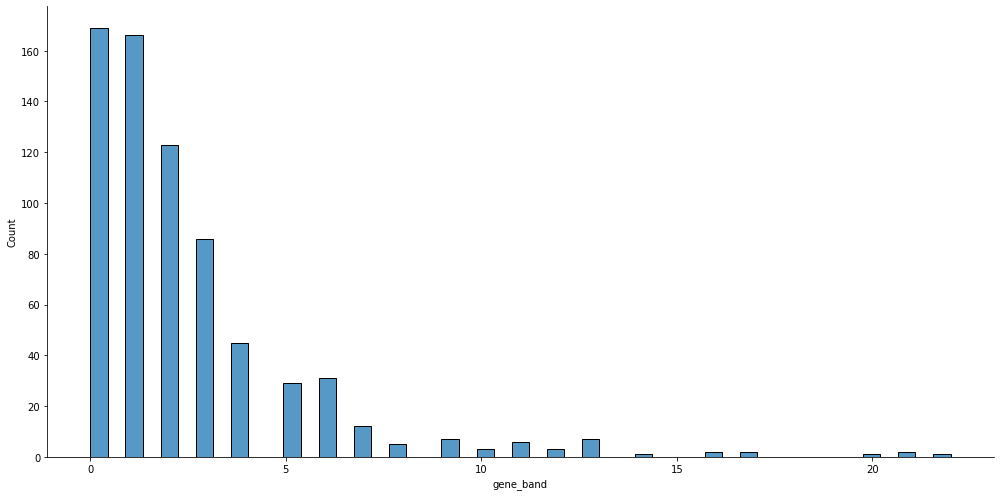

In [49]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

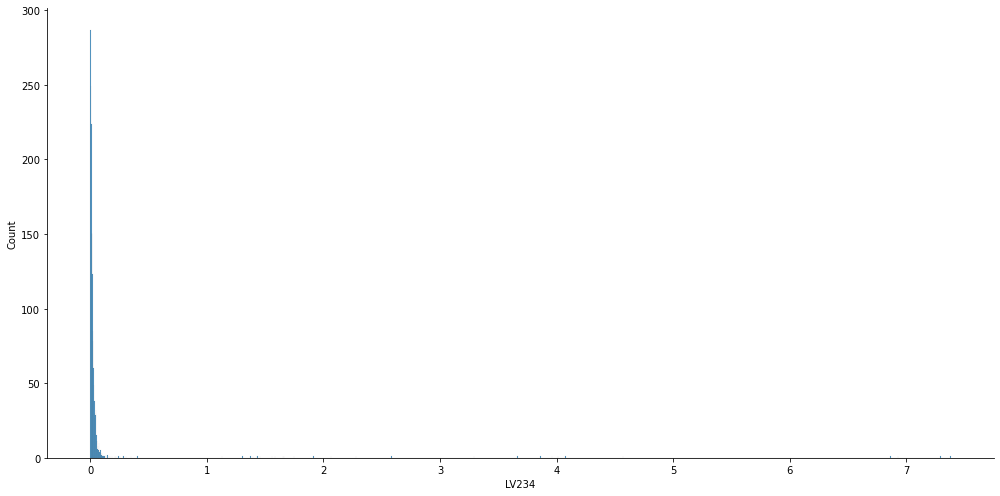

In [50]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

## LV847

In [51]:
lv_code = "LV847"

In [52]:
results = dfs[dfs["lv"] == lv_code]

In [53]:
results.shape

(1000, 7)

In [54]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
472,LV847,-0.010455,0.124795,-0.083778,0.933235,0.533382,random.pheno988
1470,LV847,-0.009900,0.125021,-0.079190,0.936884,0.531558,random.pheno589
2678,LV847,-0.072950,0.124877,-0.584174,0.559124,0.720438,random.pheno385
3408,LV847,0.011754,0.124885,0.094115,0.925020,0.462510,random.pheno5
4330,LV847,0.025660,0.125007,0.205269,0.837368,0.418684,random.pheno74


### Mean type I errors at different thresholds

In [55]:
show_prop(results, 0.01)

0.068

In [56]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.13

In [57]:
show_prop(results, 0.10)

0.179

In [58]:
show_prop(results, 0.15)

0.218

In [59]:
show_prop(results, 0.20)

0.266

### QQplot

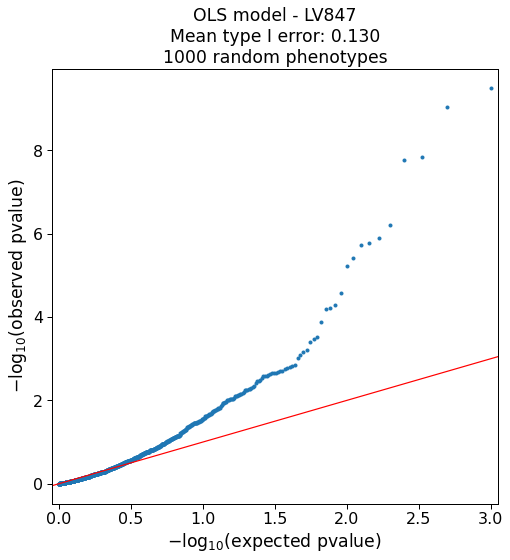

In [60]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [61]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV847,gene_band
HIST1H3D,6.805370,6p22.2
HIST1H3H,6.276783,6p22.1
HIST1H3B,6.099625,6p22.2
HIST1H4E,5.971181,6p22.2
HIST4H4,5.431832,12p12.3
HIST1H2BH,5.150647,6p22.2
HIST1H2AE,4.324334,6p22.2
HIST1H2BN,4.269944,6p22.1
HIST1H2BE,4.258760,6p22.2
HIST1H2AC,4.046811,6p22.2


In [62]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2     15
6p22.1      5
1q42.13     2
11q23.3     1
17q25.1     1
12p12.3     1
17q23.2     0
18q12.2     0
18q12.1     0
18q11.2     0
Name: gene_band, dtype: int64

**Note**: same as LV234

In [63]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [64]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(1434, 2)

In [65]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.2     20
19p13.3     18
2q35        16
6p21.33     16
19q13.42    16
16p13.3     16
6p22.2      15
19q13.33    14
3p21.31     14
19q13.2     13
Name: gene_band, dtype: int64

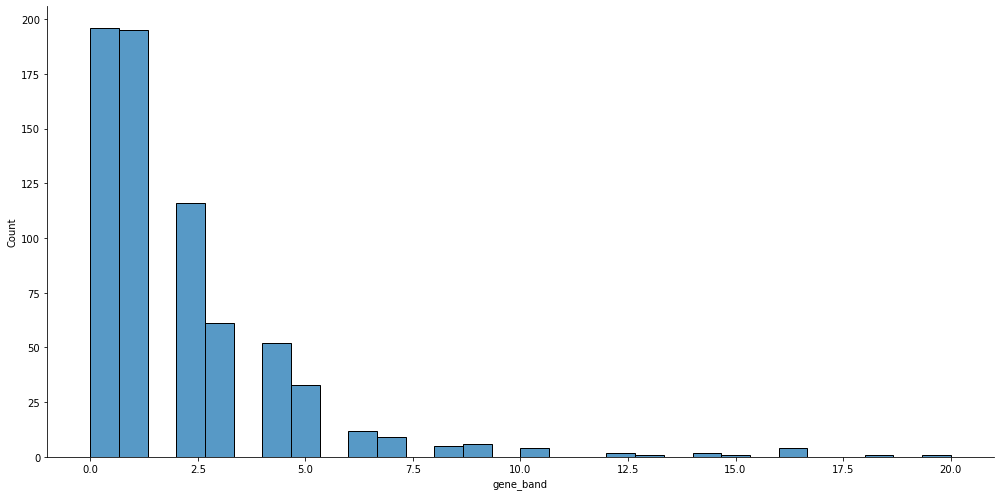

In [66]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

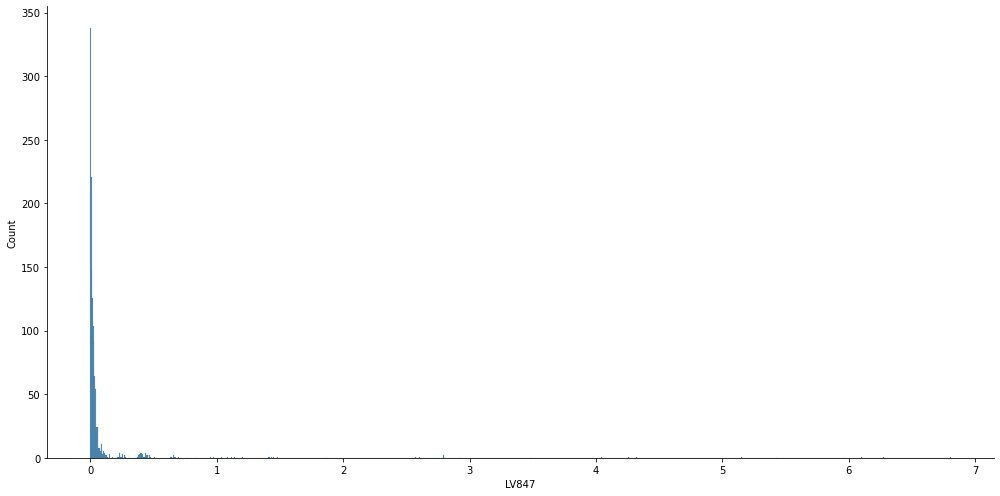

In [67]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

## LV45

In [68]:
lv_code = "LV45"

In [69]:
results = dfs[dfs["lv"] == lv_code]

In [70]:
results.shape

(1000, 7)

In [71]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
930,LV45,-0.197629,0.124679,-1.585110,0.112991,0.943505,random.pheno988
1328,LV45,0.041218,0.124927,0.329933,0.741462,0.370731,random.pheno589
2193,LV45,0.091776,0.124783,0.735484,0.462072,0.231036,random.pheno385
3494,LV45,-0.017077,0.124792,-0.136841,0.891161,0.554420,random.pheno5
4381,LV45,0.010845,0.124915,0.086819,0.930818,0.465409,random.pheno74


### Mean type I errors at different thresholds

In [72]:
show_prop(results, 0.01)

0.065

In [73]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.126

In [74]:
show_prop(results, 0.10)

0.188

In [75]:
show_prop(results, 0.15)

0.228

In [76]:
show_prop(results, 0.20)

0.272

### QQplot

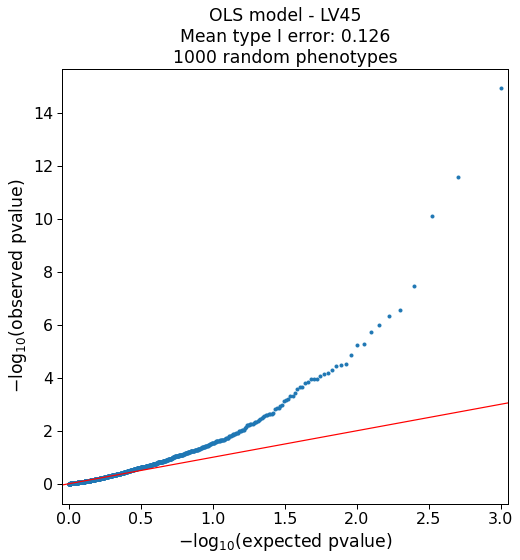

In [77]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [78]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV45,gene_band
HIST1H2BO,8.480948,6p22.1
HIST1H2BF,8.426226,6p22.2
HIST1H2BK,8.245903,6p22.1
HIST1H2BD,8.119013,6p22.2
HIST1H2BC,7.744137,6p22.2
HIST1H2AC,7.447932,6p22.2
HIST2H2BF,6.700409,1q21.2
HIST1H2AG,6.405812,6p22.1
HIST1H2BN,5.913649,6p22.1
HIST1H2AE,5.898213,6p22.2


In [79]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2     11
6p22.1      6
1q42.13     2
1q21.2      1
11q23.3     1
1q42.12     1
17q25.1     1
4q23        1
19q13.2     1
17q24.1     0
Name: gene_band, dtype: int64

**Note**: same as LV234, very likely causing high type I errors.

In [80]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [81]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(376, 2)

In [82]:
# how are bands distributed among nonzero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

6p22.2     13
19p13.3     8
1q32.1      6
6p22.1      6
4q31.21     6
17q12       5
6p21.33     4
3p21.31     4
5q31.1      4
1q23.3      4
Name: gene_band, dtype: int64

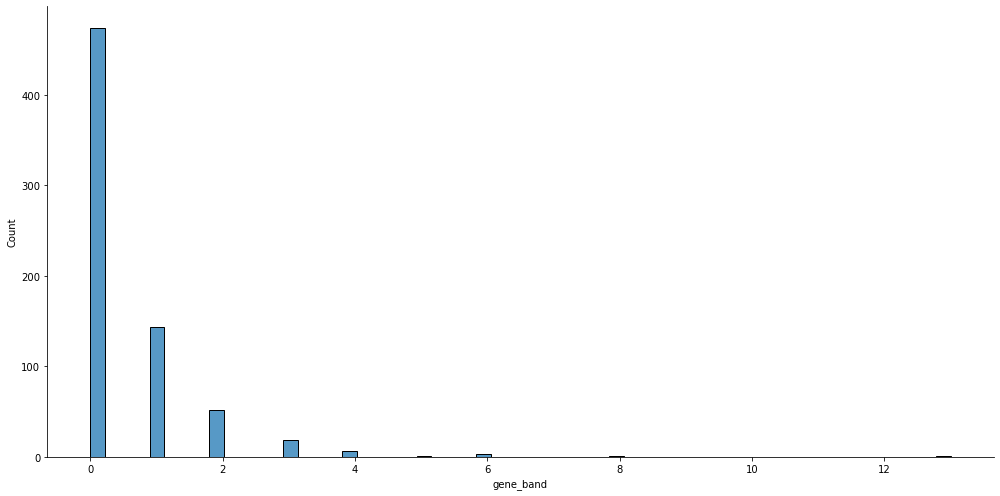

In [83]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

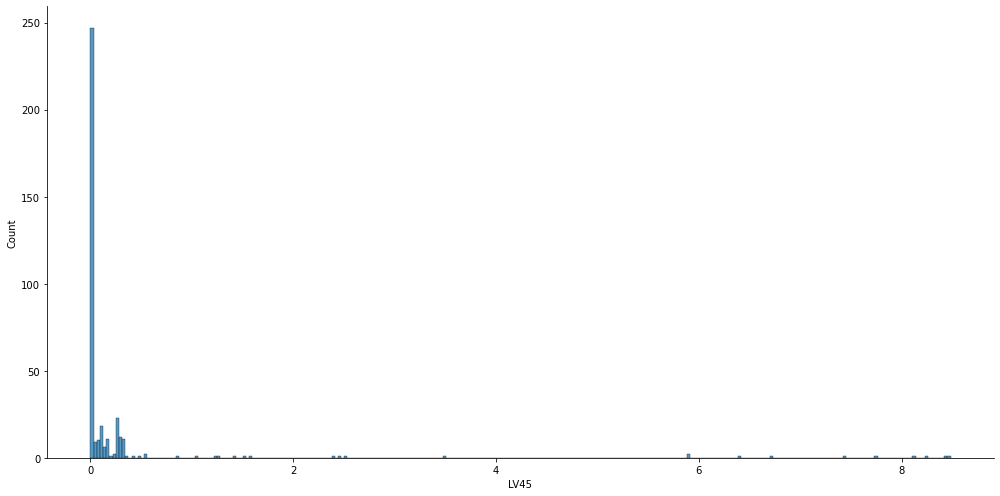

In [84]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

## LV800

In [85]:
lv_code = "LV800"

In [86]:
results = dfs[dfs["lv"] == lv_code]

In [87]:
results.shape

(1000, 7)

In [88]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
90,LV800,0.158726,0.124628,1.273599,0.202852,0.101426,random.pheno988
1347,LV800,0.033252,0.124868,0.266295,0.790021,0.395010,random.pheno589
2827,LV800,-0.132990,0.124717,-1.066333,0.286313,0.856843,random.pheno385
3852,LV800,-0.150564,0.124719,-1.207227,0.227389,0.886306,random.pheno5
4588,LV800,-0.055293,0.124853,-0.442866,0.657878,0.671061,random.pheno74


### Mean type I errors at different thresholds

In [89]:
show_prop(results, 0.01)

0.055

In [90]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.126

In [91]:
show_prop(results, 0.10)

0.176

In [92]:
show_prop(results, 0.15)

0.221

In [93]:
show_prop(results, 0.20)

0.263

### QQplot

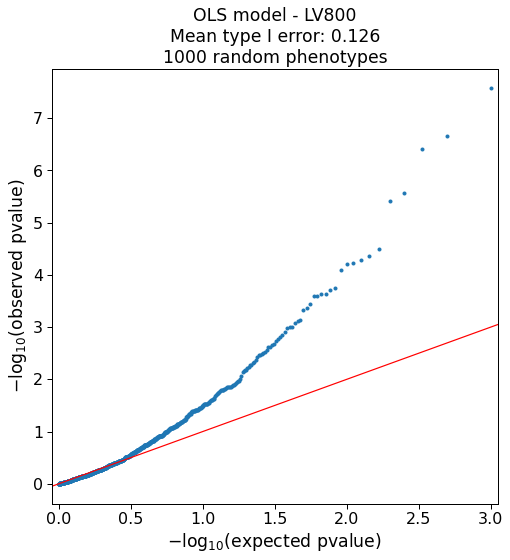

In [94]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [95]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV800,gene_band
ZNF20,1.980700,19p13.2
ZNF606,1.931659,19q13.43
ZNF551,1.832833,19q13.43
ZNF543,1.701683,19q13.43
ZNF14,1.640789,19p13.11
ZNF625,1.612766,19p13.2
ZNF234,1.608893,19q13.31
ZNF468,1.601126,19q13.41
ZFP28,1.591189,19q13.43
ZNF485,1.586159,10q11.21


**Note**: similar to the first LVs in that top genes are mostly from the same band, but here weights are way smaller.

In [96]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

19q13.43    6
19p13.2     4
19q13.31    3
19q13.41    3
10q11.21    1
7q11.21     1
19q13.12    1
19p13.11    1
19p12       1
12q24.33    1
Name: gene_band, dtype: int64

**Note**: same as LV234.

In [97]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [98]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2038, 2)

In [99]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.2     37
19q13.43    32
19q13.2     27
19p13.3     27
16p13.3     22
19q13.41    22
19q13.12    21
19p13.11    18
11q13.1     17
11q13.2     17
Name: gene_band, dtype: int64

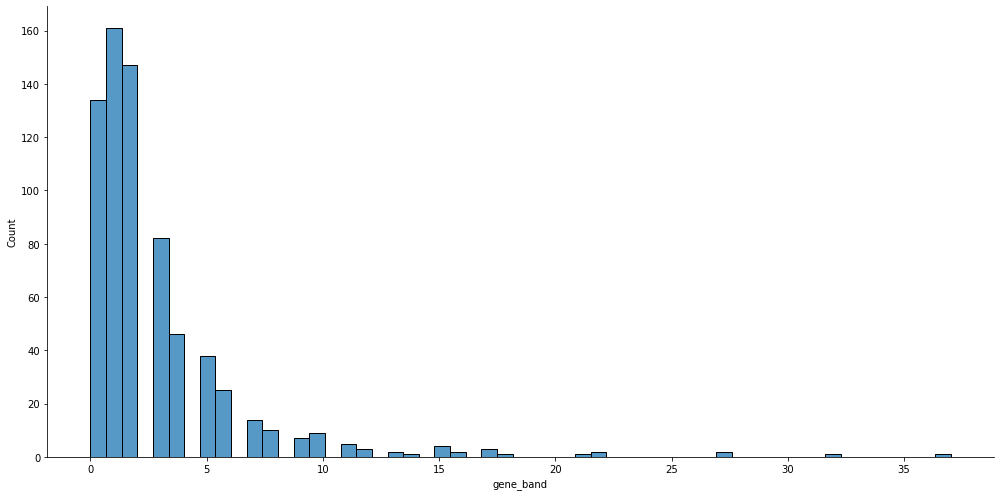

In [100]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

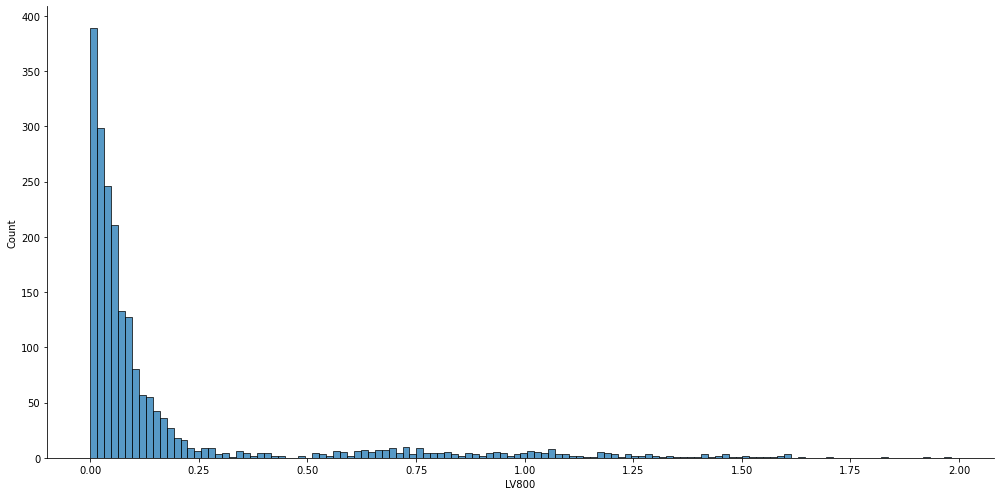

In [101]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

## LV914

In [102]:
lv_code = "LV914"

In [103]:
results = dfs[dfs["lv"] == lv_code]

In [104]:
results.shape

(1000, 7)

In [105]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
65,LV914,0.183580,0.124554,1.473897,0.140558,0.070279,random.pheno988
1548,LV914,-0.036628,0.124799,-0.293494,0.769154,0.615423,random.pheno589
2762,LV914,-0.104254,0.124653,-0.836353,0.402988,0.798506,random.pheno385
3419,LV914,0.006727,0.124665,0.053963,0.956966,0.478483,random.pheno5
4576,LV914,-0.051106,0.124785,-0.409552,0.682148,0.658926,random.pheno74


### Mean type I errors at different thresholds

In [106]:
show_prop(results, 0.01)

0.041

In [107]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.113

In [108]:
show_prop(results, 0.10)

0.19

In [109]:
show_prop(results, 0.15)

0.247

In [110]:
show_prop(results, 0.20)

0.3

### QQplot

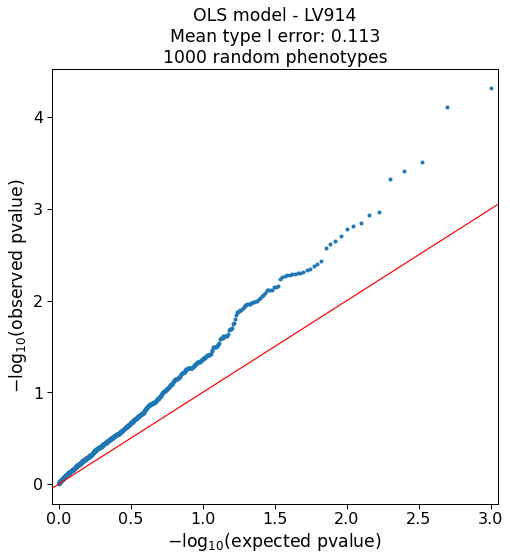

In [111]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [112]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV914,gene_band
IL23A,6.258103,12q13.3
AKT2,5.248118,19q13.2
HOXA5,2.588375,7p15.2
LAMA2,2.255515,6q22.33
RNF8,1.722023,6p21.2
PAPOLG,1.398173,2p16.1
MBD4,1.376868,3q21.3
TBK1,1.328314,12q14.2
CBLB,1.305683,3q13.11
DOK1,1.219439,2p13.1


**Note**: Ok, first LV that does not have genes from the same band at the top, but results are still not calibrated.

In [113]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

19q13.2    2
2p13.1     1
6p21.2     1
12q22      1
6p22.3     1
8q22.1     1
8p11.21    1
3q21.3     1
2q35       1
13q13.3    1
Name: gene_band, dtype: int64

In [114]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [115]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2891, 2)

In [116]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.3     34
19q13.2     33
19p13.2     31
16p13.3     29
19q13.33    28
1q21.3      27
3p21.31     26
17p13.1     24
19p13.11    24
19q13.42    23
Name: gene_band, dtype: int64

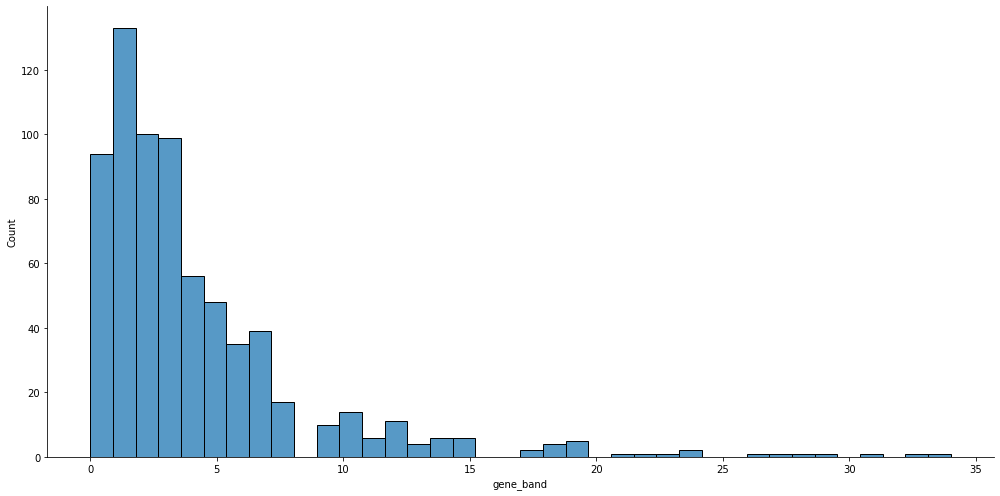

In [117]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

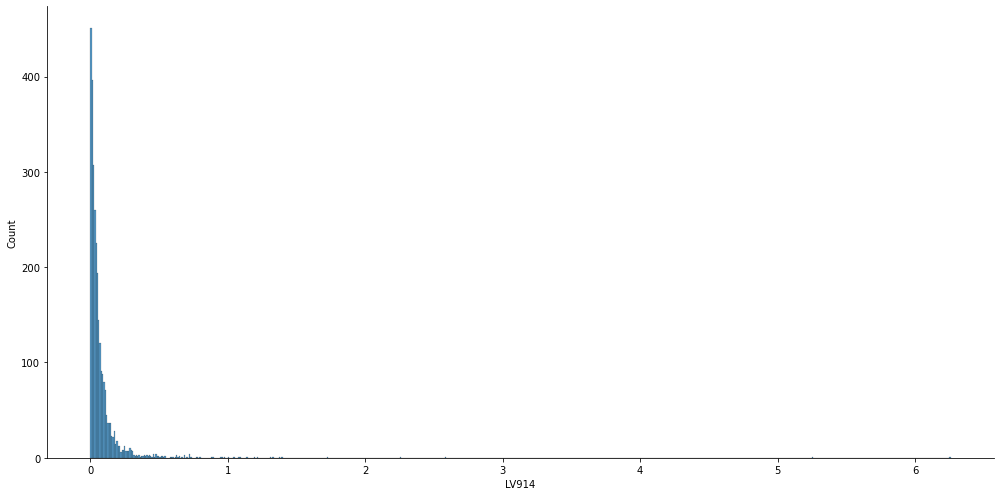

In [118]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

## LV189

In [119]:
lv_code = "LV189"

In [120]:
results = dfs[dfs["lv"] == lv_code]

In [121]:
results.shape

(1000, 7)

In [122]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
945,LV189,-0.221077,0.124508,-1.775607,0.075845,0.962078,random.pheno988
1152,LV189,0.115383,0.124755,0.924873,0.355067,0.177533,random.pheno589
2179,LV189,0.098422,0.124617,0.789796,0.429676,0.214838,random.pheno385
3520,LV189,-0.025108,0.124628,-0.201465,0.840341,0.579829,random.pheno5
4245,LV189,0.056064,0.124748,0.449415,0.653148,0.326574,random.pheno74


### Mean type I errors at different thresholds

In [123]:
show_prop(results, 0.01)

0.044

In [124]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.111

In [125]:
show_prop(results, 0.10)

0.167

In [126]:
show_prop(results, 0.15)

0.214

In [127]:
show_prop(results, 0.20)

0.263

### QQplot

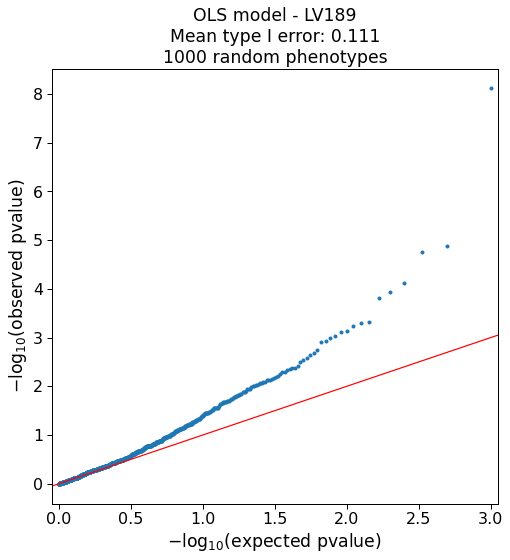

In [128]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [129]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV189,gene_band
TCN1,7.445036,11q12.1
ALDH3B2,4.980042,11q13.2
MED1,4.384997,17q12
PSMD3,4.113116,17q21.1
CDK12,2.875934,17q12
PIP4K2B,2.794035,17q12
ERBB2,2.676997,17q12
MED24,2.188042,17q21.1
PIGO,1.995728,9p13.3
ACACA,1.773115,17q12


In [130]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

17q12       6
20q11.22    4
17q21.1     2
11q13.2     1
20q13.32    1
9p13.3      1
18q21.31    1
17p13.1     1
3q27.1      1
20q13.12    1
Name: gene_band, dtype: int64

In [131]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [132]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2505, 2)

In [133]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

16p13.3     35
19p13.2     33
11q13.1     31
17q12       28
19p13.3     26
12q24.31    25
19q13.2     25
17q25.3     21
16q22.1     20
17q11.2     20
Name: gene_band, dtype: int64

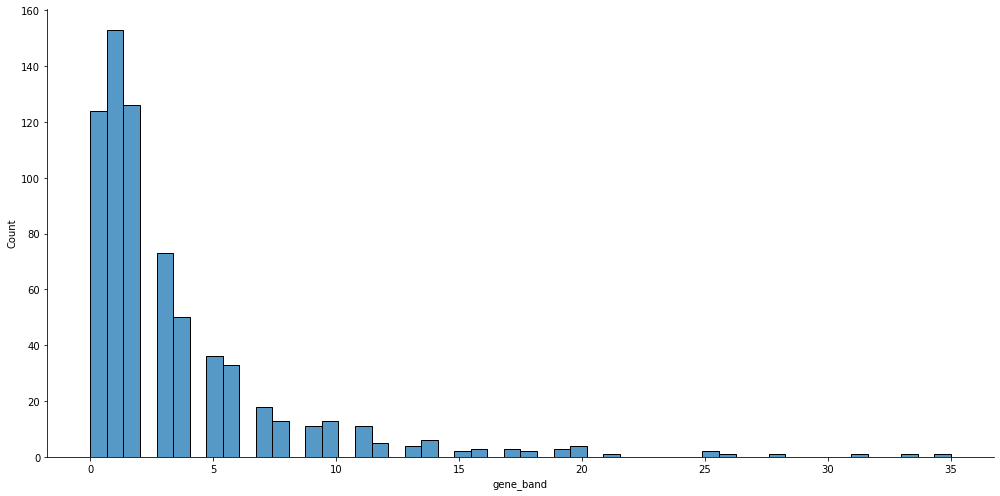

In [134]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

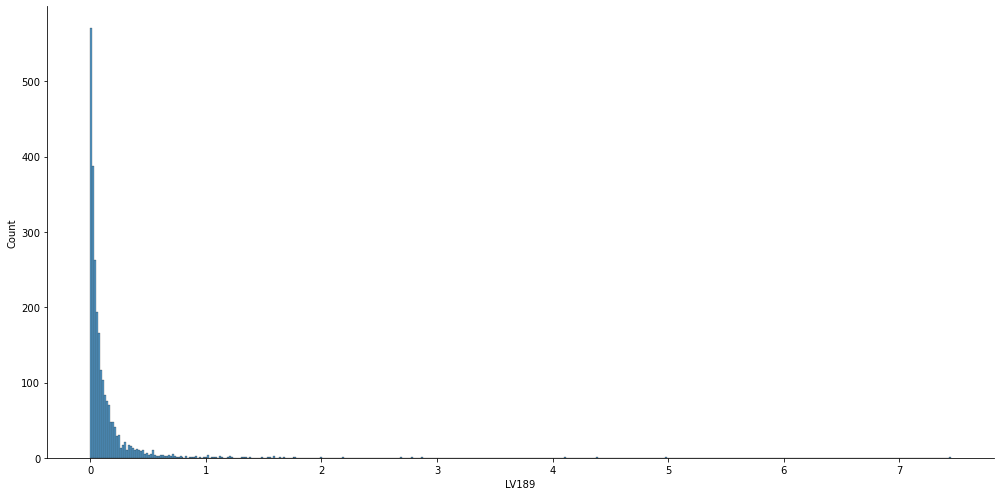

In [135]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

# LVs with expected mean type I error

In [136]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
934,LV940,0.014,0.049,0.086
578,LV62,0.015,0.049,0.089
753,LV778,0.010,0.049,0.096
746,LV771,0.015,0.049,0.098
386,LV447,0.008,0.049,0.090
395,LV455,0.016,0.049,0.098
398,LV458,0.011,0.049,0.085
257,LV330,0.010,0.049,0.096
407,LV466,0.012,0.049,0.094
702,LV731,0.006,0.049,0.081


Here I'm manually selecting from this list, since I want those that are well calibrated across different p-value thresholds.

## LV924

In [137]:
lv_code = "LV924"

In [138]:
results = dfs[dfs["lv"] == lv_code]

In [139]:
results.shape

(1000, 7)

In [140]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
522,LV924,-0.024598,0.124579,-0.197446,0.843485,0.578258,random.pheno988
1692,LV924,-0.089025,0.124800,-0.713343,0.475659,0.762170,random.pheno589
2517,LV924,-0.018074,0.124664,-0.144982,0.884730,0.557635,random.pheno385
3306,LV924,0.046068,0.124668,0.369527,0.711747,0.355874,random.pheno5
4929,LV924,-0.270906,0.124746,-2.171668,0.029917,0.985041,random.pheno74


### Mean type I errors at different thresholds

In [141]:
show_prop(results, 0.01)

0.009

In [142]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.049

In [143]:
show_prop(results, 0.10)

0.096

In [144]:
show_prop(results, 0.15)

0.135

In [145]:
show_prop(results, 0.20)

0.178

### QQplot

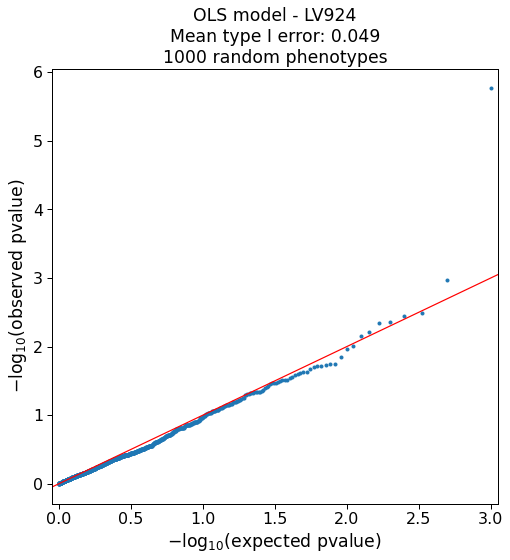

In [146]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

Hm, well calibrated in general, but with one small pvalue.

### Top genes in LV

In [147]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV924,gene_band
GALC,7.681284,14q31.3
NMNAT2,5.648588,1q25.3
RPL41,3.884772,12q13.2
UBA2,2.643791,19q13.11
ATP1B3,1.863783,3q23
FKBP14,1.573648,7p14.3
PAPOLB,1.234690,7p22.1
CEP192,1.164243,18p11.21
GAB2,1.092178,11q14.1
HRH4,1.016745,18q11.2


In [148]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

18q11.2     2
15q15.2     1
4q31.21     1
9p24.1      1
1q25.3      1
4p15.2      1
9q21.11     1
18p11.21    1
11p15.1     1
11q14.1     1
Name: gene_band, dtype: int64

In [149]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [150]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2455, 2)

In [151]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

16p13.3     39
1q21.3      29
19q13.2     26
17p13.1     24
19p13.3     24
17q25.3     20
3p21.31     20
6p21.33     19
19p13.2     19
19q13.33    18
Name: gene_band, dtype: int64

Similar to LV769.

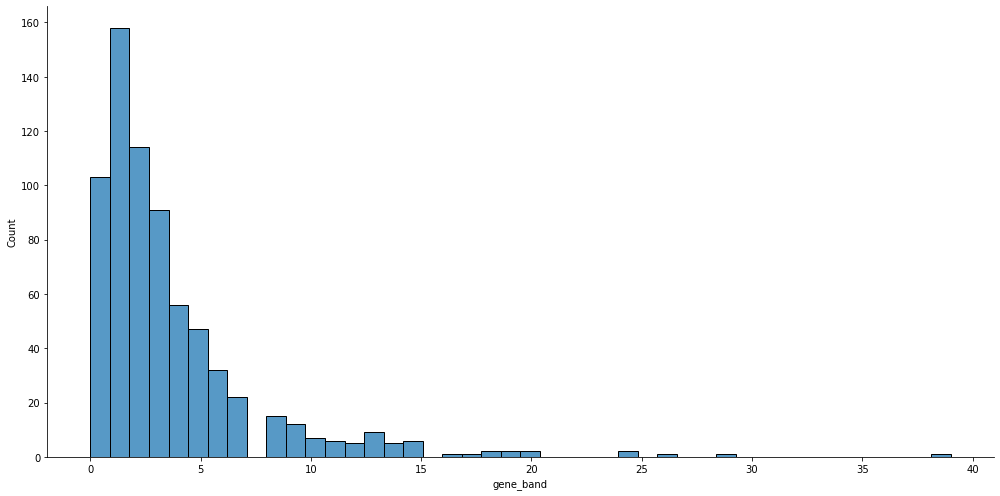

In [152]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

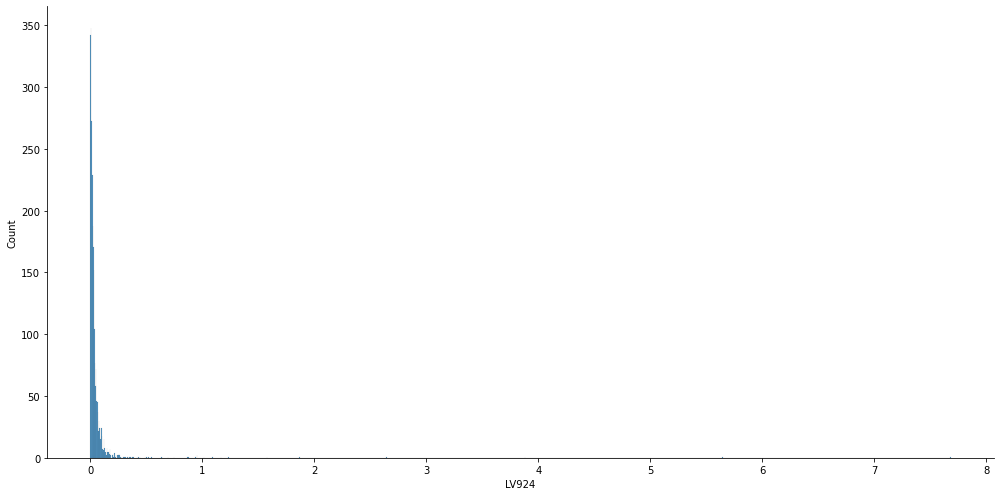

In [153]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

## LV675

In [154]:
lv_code = "LV675"

In [155]:
results = dfs[dfs["lv"] == lv_code]

In [156]:
results.shape

(1000, 7)

In [157]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
925,LV675,-0.193009,0.124676,-1.548087,0.121651,0.939175,random.pheno988
1441,LV675,-0.000207,0.124924,-0.001660,0.998675,0.500662,random.pheno589
2171,LV675,0.101580,0.124777,0.814092,0.415623,0.207811,random.pheno385
3781,LV675,-0.111110,0.124781,-0.890441,0.373262,0.813369,random.pheno5
4333,LV675,0.025379,0.124910,0.203178,0.839003,0.419501,random.pheno74


### Mean type I errors at different thresholds

In [158]:
show_prop(results, 0.01)

0.011

In [159]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.049

In [160]:
show_prop(results, 0.10)

0.1

In [161]:
show_prop(results, 0.15)

0.146

In [162]:
show_prop(results, 0.20)

0.199

### QQplot

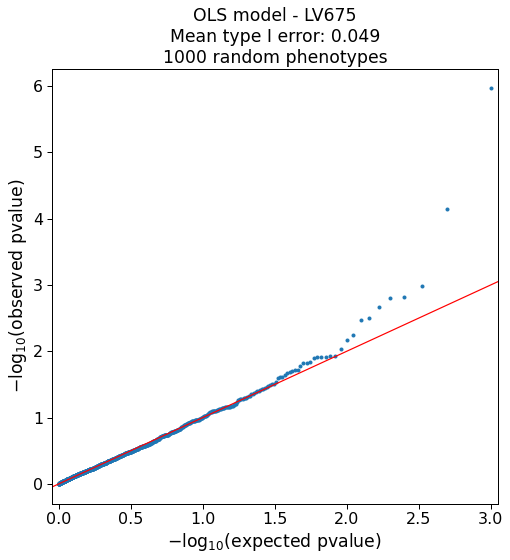

In [163]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

Same as before, well calibrated, with one very small pvalue.

### Top genes in LV

In [164]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV675,gene_band
CASS4,6.708751,20q13.31
PDE4B,5.987527,1p31.3
OSM,5.822618,22q12.2
SOCS3,5.453257,17q25.3
LCP2,3.100119,5q35.1
PLEK,3.085603,2p14
PROK2,2.669296,3p13
PPIF,2.579872,10q22.3
PTGS2,2.371748,1q31.1
TREM1,2.315952,6p21.1


In [165]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

1q32.2      2
6p21.1      2
2p14        2
8p21.3      1
5q35.1      1
14q31.3     1
1p31.3      1
7q22.3      1
20p11.21    1
1q32.1      1
Name: gene_band, dtype: int64

In [166]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [167]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2362, 2)

Similar to LV769 and LV412

In [168]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.3     30
19q13.42    28
19q13.2     26
16p13.3     23
17p13.1     23
3p21.31     20
17q25.3     20
11q13.1     19
19q13.33    18
19p13.2     18
Name: gene_band, dtype: int64

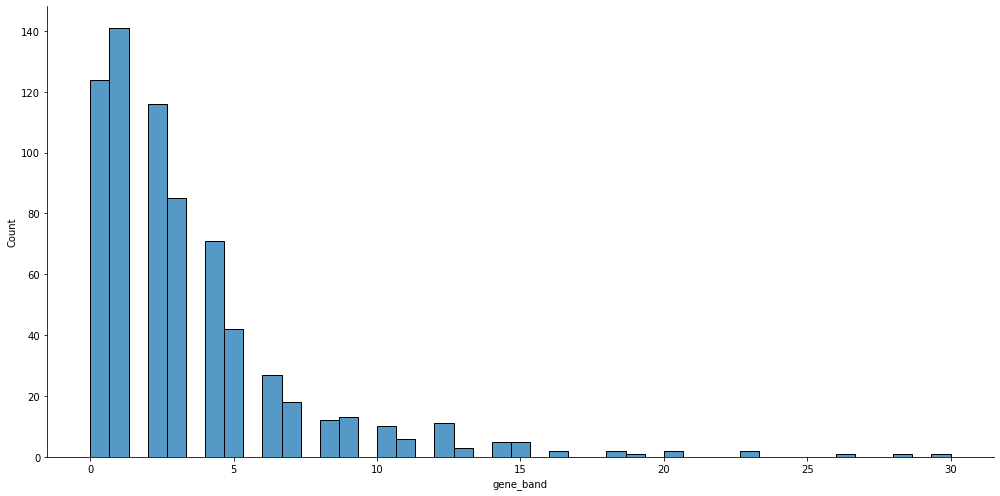

In [169]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

The distribution seems similar to LV412, but here we have smaller bands.

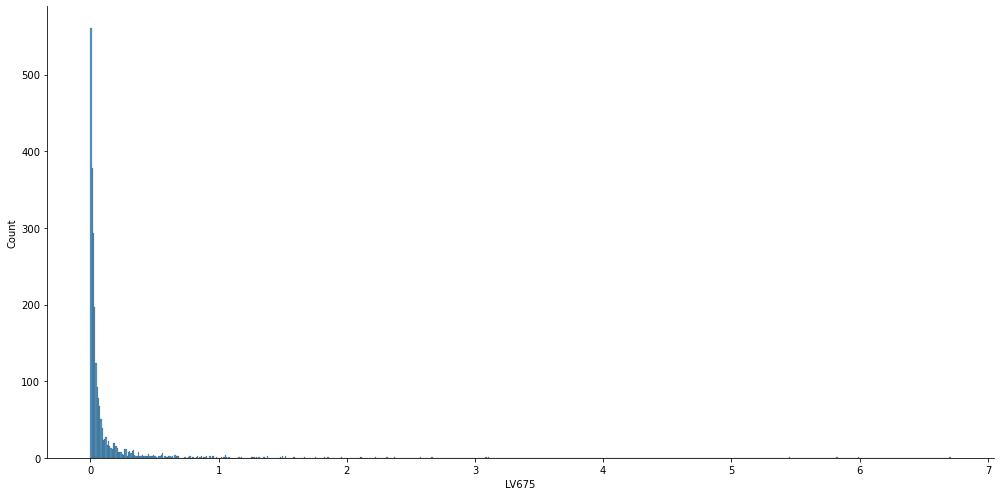

In [170]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

## LV691

In [171]:
lv_code = "LV691"

In [172]:
results = dfs[dfs["lv"] == lv_code]

In [173]:
results.shape

(1000, 7)

In [174]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
96,LV691,0.155195,0.124585,1.245696,0.212922,0.106461,random.pheno988
1842,LV691,-0.143068,0.124813,-1.146263,0.251729,0.874136,random.pheno589
2312,LV691,0.042391,0.124684,0.339987,0.733878,0.366939,random.pheno385
3195,LV691,0.087114,0.124685,0.698675,0.484780,0.242390,random.pheno5
4121,LV691,0.117582,0.124803,0.942138,0.346158,0.173079,random.pheno74


### Mean type I errors at different thresholds

In [175]:
show_prop(results, 0.01)

0.013

In [176]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.049

In [177]:
show_prop(results, 0.10)

0.098

In [178]:
show_prop(results, 0.15)

0.16

In [179]:
show_prop(results, 0.20)

0.198

### QQplot

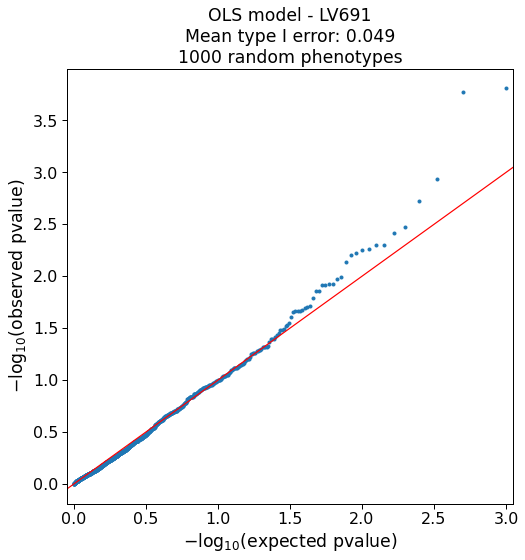

In [180]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"OLS model - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [181]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV691,gene_band
SEPSECS,3.933431,4p15.2
DEPTOR,2.957233,8q24.12
TARS2,2.430542,1q21.2
AQR,2.370997,15q14
KLC4,2.108343,6p21.1
UNG,2.028480,12q24.11
COQ2,2.016418,4q21.23
NTAN1,1.956672,16p13.11
CD2,1.938323,1p13.1
TNFSF13B,1.789970,13q33.3


In [182]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

4q12       2
7p13       1
15q14      1
1q21.2     1
13q33.3    1
6p21.1     1
8q21.3     1
4p15.2     1
17p13.3    1
17p13.2    1
Name: gene_band, dtype: int64

In [183]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [184]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(3138, 2)

In [185]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.3     40
16p13.3     36
19p13.2     32
19q13.2     29
19q13.33    24
12q24.31    24
3p21.31     24
17p13.1     23
1q21.3      22
16p11.2     22
Name: gene_band, dtype: int64

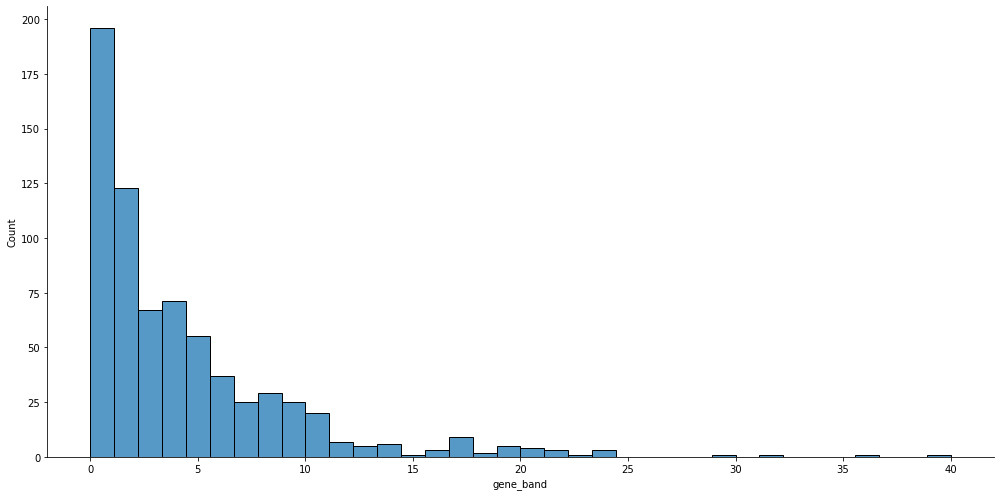

In [186]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

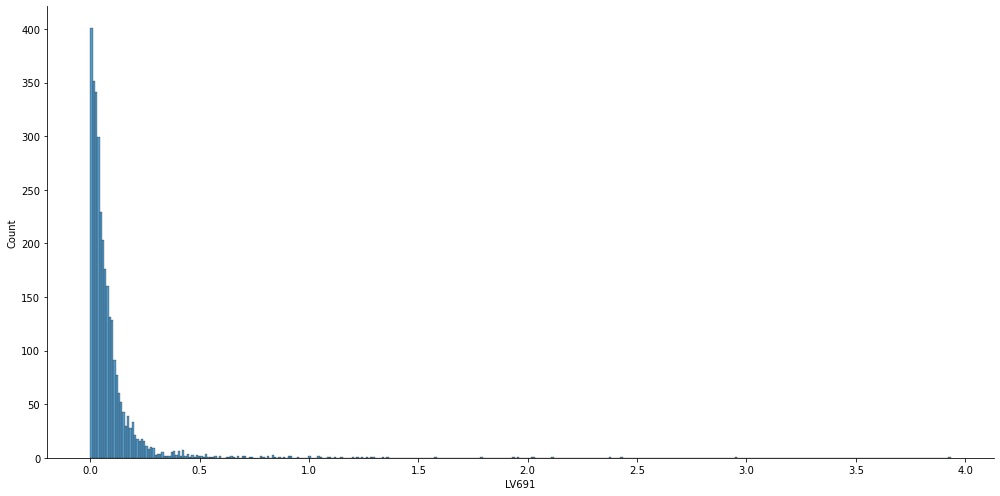

In [187]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

# Conclusions

Looks like not-well-calibrated LVs are mainly due to too many top genes from the same band.

However, some LVs, like LV914, are not driven by top genes from the same band.